## 회귀분석 - 경사하강법

## 1. 라이브러리 imports

In [1]:
import torch
import matplotlib.pyplot as plt

## 2. 회귀모형

> 우리가 배운 그 모형...

$$\boldsymbol{y} = \boldsymbol{XW} + \boldsymbol{\epsilon}$$

### **A. 회귀모형에서 데이터 생성**

---



In [25]:
torch.manual_seed(43052)
ones = torch.ones(100).reshape(-1, 1)  ## 100, 1 matrix
x,_ = torch.randn(100).sort()  ## output sorted random number / index list. _ is dummy for indices
x = x.reshape(-1, 1)  ## as column vector
X = torch.concat([ones, x], axis = -1)  ## -1부터 열, 행, 추가된 차수로 이해하면 되니까 이렇게 하신 듯
W = torch.tensor([[2.5], [4]])
e = torch.randn(100).reshape(-1, 1)*0.5
y = X@W + e

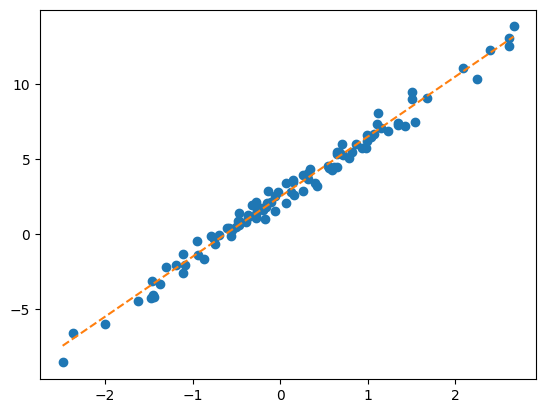

In [26]:
plt.plot(x, y, 'o')
plt.plot(x, 2.5 + 4*x, '--')
plt.show()

`-` 시도 : $(\hat{w_0}, \hat{w_1}) = (-5, 10)$을 선택하여 선을 그려보고 적당한지 판단 & 인간의 지능을 활용하여 더 나은 선을 찾아보자.

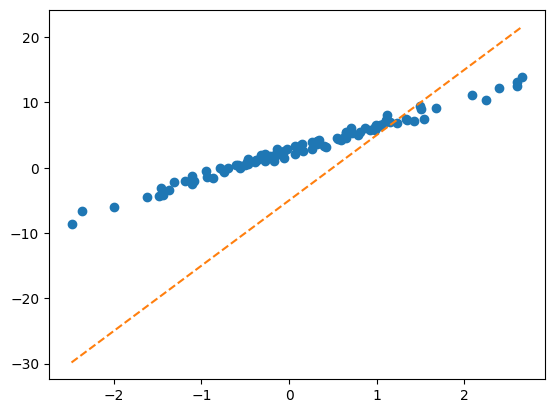

In [27]:
plt.plot(x, y, 'o')
plt.plot(x, -5+10*x, '--')
plt.show()

`-` 벡터표현으로 주황색 점선을 계산

In [28]:
W_hat = torch.tensor([[-5.0], [10.0]])  ## column vector
X.shape

torch.Size([100, 2])

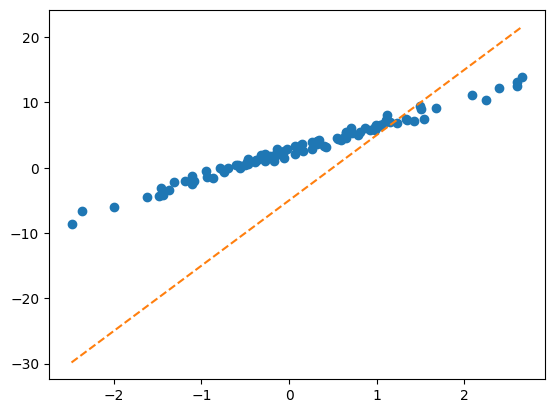

In [29]:
plt.plot(x, y, 'o')
plt.plot(x, X@W_hat, '--')
plt.show()

> 일단 이건 망한 학습인 것 같다...

## 3. 학습 전략

1. 아무 점선이나 그려본다.
2. 1단계에서 그은 점선보다 더 좋은 점선으로 바꾼다. $\to$ 이걸 어떻게 할까?
3. 1~2단계를 반복한다.

> 컴퓨터의 반복계산을 이용하여 추론(손실함수 + 경사하강법)

## 4. `1단계` 실습 - 최초의 직선

`-` 그냥 $\hat w_0 = -5, \hat w_1 = 10$으로 설정하고 임의의 선을 그어보자.

In [30]:
W_hat = torch.tensor([[-5.0], [10.0]], requires_grad = True)
W_hat

tensor([[-5.],
        [10.]], requires_grad=True)

> 끝에 `requires_grad = True`는 나중에 미분을 위한 것, 그래디언트가 필요하다는 거임...

In [31]:
y_hat = X@W_hat
y_hat

tensor([[-29.8211],
        [-28.6215],
        [-24.9730],
        [-21.2394],
        [-19.7919],
        [-19.6354],
        [-19.5093],
        [-19.4352],
        [-18.7223],
        [-18.0793],
        [-16.9040],
        [-16.0918],
        [-16.0536],
        [-15.8746],
        [-14.4690],
        [-14.3193],
        [-13.6426],
        [-12.8578],
        [-12.5486],
        [-12.4213],
        [-11.9484],
        [-11.1034],
        [-10.8296],
        [-10.6210],
        [-10.5064],
        [-10.0578],
        [ -9.8063],
        [ -9.7380],
        [ -9.7097],
        [ -9.6756],
        [ -8.8736],
        [ -8.7195],
        [ -8.6880],
        [ -8.1592],
        [ -7.7752],
        [ -7.7716],
        [ -7.7339],
        [ -7.7208],
        [ -7.6677],
        [ -7.1551],
        [ -7.0004],
        [ -6.8163],
        [ -6.7081],
        [ -6.5655],
        [ -6.4480],
        [ -6.3612],
        [ -6.0566],
        [ -5.6031],
        [ -5.5589],
        [ -5.2137],


In [32]:
# plt.plot(x, y, 'o')
# plt.plot(x, y_hat, '--')

> 그리드가 있어서 못함, 따라서 데이터만 받아서 해줘야 함.

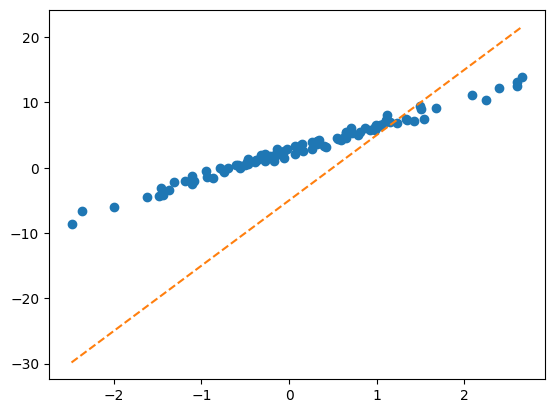

In [33]:
plt.plot(x, y, 'o')
plt.plot(x, y_hat.data, '--')  ## 그림을 그리기 위해 y_hat의 미분꼬리표를 제거
plt.show()

## 5. `2단계` 실습 : 업데이트

> 최초의 점선에 대한 '적당한 정도'를 판단하고, 더 '적당한' 점선으로 업데이트한다.

### **A. 손실함수**


---



`-` '적당한 정도'를 판단하기 위한 장치 : loss function

$loss = \Sigma_{i = 1}^{n}(y_i - \hat{y}_i)^2 = \Sigma_{i = 1}^{n}(y_i - (\hat w_0 + \hat w_1 x_i))^2$

$= (\boldsymbol y - \boldsymbol{\hat{y}})^{\top}(\boldsymbol y - \boldsymbol{\hat{y}}) = (\boldsymbol y - \boldsymbol{XW})^{\top}(\boldsymbol y - \boldsymbol{XW})$

`-` loss 함수의 특징

* $y_i \approx \hat y_i$일수록 loss값이 작다.
* $y_i \approx \hat y_i$이 되도록 $(\hat w_0, \hat w_1)$을 잘 택하면 loss값이 작다.
* **(중요)** 주황색 점선이 '적당할 수록' loss값이 작다.

In [34]:
loss = torch.sum((y - y_hat)**2)
loss

tensor(8587.6875, grad_fn=<SumBackward0>)

`-` 우리의 목표 : 이 loss(=8587.6875)를 더 줄이자.

> 궁극적으로는 아예 가능한 모든 조합 $(\hat w_0, \hat w_1)$에 대하여 가장 작은 loss를 찾으면 좋겠다. (단계 2에서 할 일은 아님...)

`-` 문제의 치환 : 생각해보니까, 우리의 문제는 수학적으로 단순화되었다.

> 계수에 대해 convex한 function을 가정하면, 해당 값의 기울기(그래디언트, 접평면의 기울기) 방향으로 계수들의 값을 이동시키며 극값에 근사할 수 있다. 이 경우 극소값에서 멈춘다...

* 접선의 기울기 부호와 반대방향으로, 그 기울기만큼 가중치를 주어 움직인다. 기울기가 크면 많이 이동하고, 적으면 근처에 있다는 것이니까 조금만 이동한다.

`-` 경사 하강법 아이디어 (1차원)

1) 임의의 점을 찍는다.
2) 해당 점에서의 기울기를 구하고 기울기의 부호와 반대방향으로 이동한다.
3) 기울기의 절댓값과 비례하여 이동한다.

`-` 경사 하강법 아이디어 (2차원)

1) 임의의 점을 찍는다.
2) 해당 점에서의 순간기울기를 구한다. (접평면) <- 각각 편미분
3) 기울기의 절댓값 크기와 비례하여 움직이는 정도를 각각 조정한다.

`-` 계산식

* 수정값 = 원래값 - 기울어진크기(=미분계수)

$\boldsymbol W \leftarrow \boldsymbol W - \boldsymbol a \times \frac{\partial}{\partial w} loss(w)$

## 6. 모델링


### **A. 데이터**
`-` 아이스아메리카노 판매량이 평균기온과 선형 관계가 있는 것 같음.

In [2]:
temp = [-2.4821, -2.3621, -1.9973, -1.6239, -1.4792, -1.4635, -1.4509, -1.4435,
        -1.3722, -1.3079, -1.1904, -1.1092, -1.1054, -1.0875, -0.9469, -0.9319,
        -0.8643, -0.7858, -0.7549, -0.7421, -0.6948, -0.6103, -0.5830, -0.5621,
        -0.5506, -0.5058, -0.4806, -0.4738, -0.4710, -0.4676, -0.3874, -0.3719,
        -0.3688, -0.3159, -0.2775, -0.2772, -0.2734, -0.2721, -0.2668, -0.2155,
        -0.2000, -0.1816, -0.1708, -0.1565, -0.1448, -0.1361, -0.1057, -0.0603,
        -0.0559, -0.0214,  0.0655,  0.0684,  0.1195,  0.1420,  0.1521,  0.1568,
         0.2646,  0.2656,  0.3157,  0.3220,  0.3461,  0.3984,  0.4190,  0.5443,
         0.5579,  0.5913,  0.6148,  0.6469,  0.6469,  0.6523,  0.6674,  0.7059,
         0.7141,  0.7822,  0.8154,  0.8668,  0.9291,  0.9804,  0.9853,  0.9941,
         1.0376,  1.0393,  1.0697,  1.1024,  1.1126,  1.1532,  1.2289,  1.3403,
         1.3494,  1.4279,  1.4994,  1.5031,  1.5437,  1.6789,  2.0832,  2.2444,
         2.3935,  2.6056,  2.6057,  2.6632]

In [3]:
sales= [-8.5420, -6.5767, -5.9496, -4.4794, -4.2516, -3.1326, -4.0239, -4.1862,
        -3.3403, -2.2027, -2.0262, -2.5619, -1.3353, -2.0466, -0.4664, -1.3513,
        -1.6472, -0.1089, -0.3071, -0.6299, -0.0438,  0.4163,  0.4166, -0.0943,
         0.2662,  0.4591,  0.8905,  0.8998,  0.6314,  1.3845,  0.8085,  1.2594,
         1.1211,  1.9232,  1.0619,  1.3552,  2.1161,  1.1437,  1.6245,  1.7639,
         1.6022,  1.7465,  0.9830,  1.7824,  2.1116,  2.8621,  2.1165,  1.5226,
         2.5572,  2.8361,  3.3956,  2.0679,  2.8140,  3.4852,  3.6059,  2.5966,
         2.8854,  3.9173,  3.6527,  4.1029,  4.3125,  3.4026,  3.2180,  4.5686,
         4.3772,  4.3075,  4.4895,  4.4827,  5.3170,  5.4987,  5.4632,  6.0328,
         5.2842,  5.0539,  5.4538,  6.0337,  5.7250,  5.7587,  6.2020,  6.5992,
         6.4621,  6.5140,  6.6846,  7.3497,  8.0909,  7.0794,  6.8667,  7.4229,
         7.2544,  7.1967,  9.5006,  9.0339,  7.4887,  9.0759, 11.0946, 10.3260,
        12.2665, 13.0983, 12.5468, 13.8340]

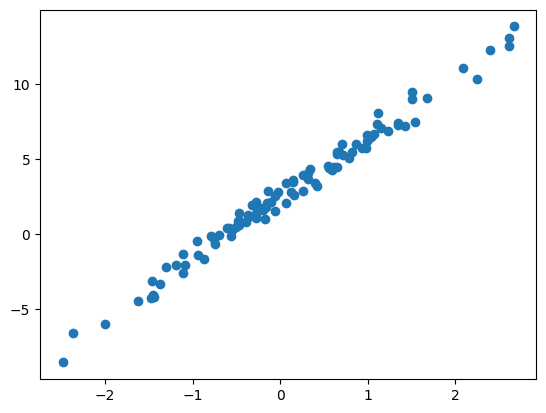

In [7]:
plt.plot(temp, sales, 'o')

$$\boldsymbol{y} = \boldsymbol{XW} + \boldsymbol{\epsilon}$$

In [20]:
X1 = torch.tensor(temp).reshape(-1,1)  ## 텐서로 먹임, column vector의 형태로.
ones = torch.ones(100).reshape(-1, 1)

In [25]:
X = torch.concat([ones, X1], axis = 1)  ## 두 번째 shape을 바꿈
y = torch.tensor(sales).reshape(-1, 1)
# W 모름
# eps 이것도 모름

### **B. 아무렇게나 추정**

In [22]:
What = torch.tensor([[-5.0], [10]])

In [23]:
yhat = X@What

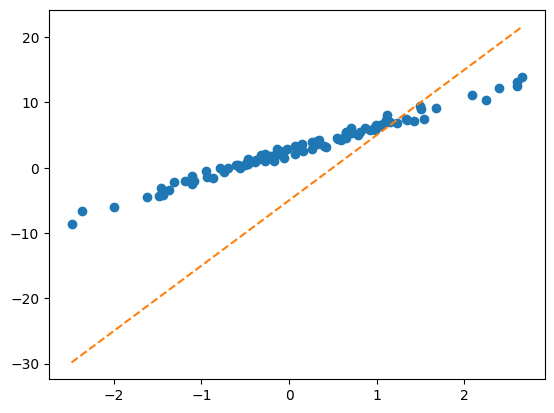

In [29]:
plt.plot(X1, y, 'o')
plt.plot(X1, yhat, '--')

### **C. 추정의 방법**

* 1. OLS(기계학습 관점)

In [31]:
lse_w = torch.linalg.inv(X.T@X)@X.T@y  ## LSE

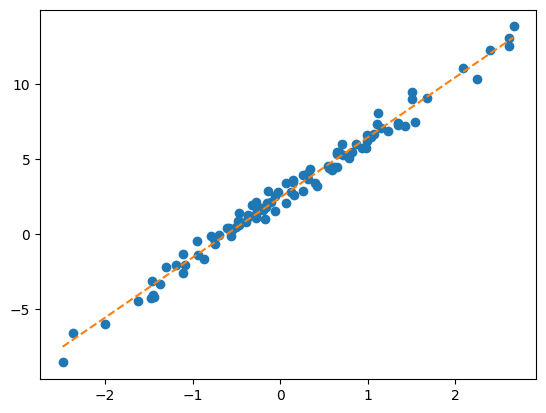

In [32]:
plt.plot(X1, y, 'o')
plt.plot(X1, X@lse_w, '--')

* **경사하강법**

1. 아무 선이나 그어본다.
2. 1단계에서 그은 선보다 더 좋은 선으로 바꾼다.(손실함수의 값이 더 작은 선)
3. 위 과정을 반복한다.

### **D. 경사하강법**

`-` 1단계 : 최초의 점선

In [34]:
What = torch.tensor([[-5.0],[10]], requires_grad = True)
yhat = X@What

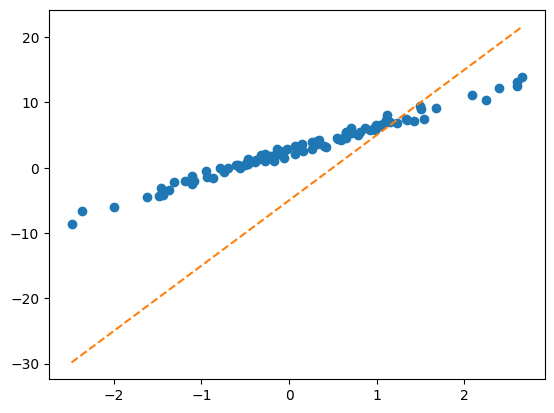

In [38]:
plt.plot(X1, y, 'o')
plt.plot(X1, yhat.data, '--')

`-` 2단계 : 업데이트

In [43]:
torch.sum((y - yhat)**2)

tensor(8587.6240, grad_fn=<SumBackward0>)

In [44]:
torch.sum((y - X@lse_w)**2)

tensor(26.3629)

> loss가 위 값까지 떨어지도록 최적화해야 한다.

$loss = SSE$

$\boldsymbol W \leftarrow \boldsymbol W - \boldsymbol a \times \frac{\partial}{\partial w} loss(w)$

In [59]:
loss = torch.sum((y - yhat)**2)

> 여기서 미분을 어떻게 하나...?

In [ ]:
loss.backward() ## 인스턴스를 먹여줌, 그것은 이제 requires_grad를 갖는 것들의 백워드가 되는듯.

In [63]:
loss

tensor(8587.6240, grad_fn=<SumBackward0>)

In [62]:
print(What.grad)  ## 경사에 대한 그래디언트가 나온다.

tensor([[-1342.2465],
        [ 1188.9203]])


In [61]:
-2*X.T@y + 2*X.T@X@What  ## 실제 수식, What으로 손실함수(스칼라)를 미분한 것

tensor([[-1342.2466],
        [ 1188.9198]], grad_fn=<AddBackward0>)

> 근데 실제로 이 값의 반대방향만큼 수정해버린다면, 우주로 날라가버릴 것 같음... $\to$ 업데이트를 조금 약하게 해주자! : $\alpha$

In [67]:
alpha = 0.001
print(f'{What.data} -- 수정 전')
print(f'{-alpha*What.grad} -- 업데이트하는 폭')
print(f'{What.data - alpha*What.grad} -- 업데이트 후')

tensor([[-5.],
        [10.]]) -- 수정 전
tensor([[ 1.3422],
        [-1.1889]]) -- 업데이트하는 폭
tensor([[-3.6578],
        [ 8.8111]]) -- 업데이트 후


`-` 업데이트 결과를 시각화

In [73]:
Wbefore = What.data
Wafter = What.data - alpha*What.grad

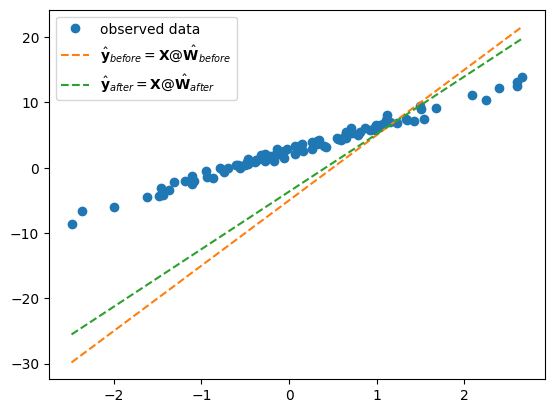

In [75]:
plt.plot(X1,y,'o',label=r'observed data')
plt.plot(X1,X@Wbefore,'--', label=r"$\hat{\bf y}_{before}={\bf X}@\hat{\bf W}_{before}$")
plt.plot(X1,X@Wafter,'--', label=r"$\hat{\bf y}_{after}={\bf X}@\hat{\bf W}_{after}$")
plt.legend()

`-` **3단계 : iteraion**